## Predicción de Retornos de BTC usando Modelos VAR y VARMAX

Vamos a explorar la construcción de modelos de series temporales multivariantes para predecir el precio de Bitcoin (BTC). Para ello usaremos dos tipos de modelos:

VAR (Vector Autoregressive): Modelo autoregresivo multivariante que usa solo variables endógenas (variables internas del sistema) para predecir sus valores futuros.

VARMAX (Vector Autoregressive Moving Average with eXogenous variables): Extensión del VAR que permite incluir variables exógenas (externas al sistema) para mejorar la predicción.

### Variables Endógenas (ENDO)

Estas son las variables que el modelo intenta predecir y que dependen unas de otras:

* `btc_log_return`: Retorno logarítmico diario de BTC
* `btc_rsi`: Indicador RSI (Relative Strength Index) de BTC
* `sp500_log_return`: Retorno logarítmico del S\&P 500
* `gold_log_return`: Retorno logarítmico del oro
* `dxy_log_return`: Retorno logarítmico del índice dólar (DXY)
* `eth_log_return`: Retorno logarítmico de Ethereum
* `trend_diff`: Diferencia en tendencia (derivada)
* `trend`: Tendencia general

### Variables Exógenas

Son variables adicionales que pueden influir en las variables endógenas pero que no se modelan como dependientes internas. Ejemplos que pueden aparecer:

* `fear_greed`: Índice de miedo/avaricia del mercado
* `active_addresses`: Número relativo de direcciones activas en la red BTC
* `active_addresses_pct_change`: Cambio porcentual en direcciones activas

### Combinaciones de Variables para Modelar

Vamos a probar varios modelos con diferentes combinaciones de variables endógenas y exógenas para analizar su desempeño.

| Modelo                                            | Variables                                                                   |
| ------------------------------------------------- | --------------------------------------------------------------------------- |
| **btc\_log\_return + btc\_rsi**                   | `btc_log_return`, `btc_rsi` (solo endógenas)                                |
| **btc\_log\_return + fear\_greed**                | `btc_log_return`, `btc_rsi` (endo) + `fear_greed` (exo)                     |
| **btc\_log\_return + trend\_diff**                | `btc_log_return` (endo) + `trend_diff` (exo)                                |
| **btc\_log\_return + active\_addr**               | `btc_log_return` (endo) + `active_addresses_pct_change` (exo)               |
| **btc\_log\_return + fear\_greed + active + rsi** | `btc_log_return`, `btc_rsi` (endo) + `fear_greed`, `active_addresses` (exo) |

### Metodología

Para cada conjunto de variables:
  * Separamos las variables en endógenas y exógenas.
  * Cargamos los datos filtrando desde una fecha de inicio acorde según las variables.
  * Ajustamos un modelo VAR (si no hay variables exógenas) o VARMAX (si hay variables exógenas).
  * Dividimos los datos en entrenamiento (80%) y testeo (20%).
  * Realizamos pronósticos en el período de testeo.
  * Evaluamos el error de predicción y graficamos resultados para `btc_log_return` y el precio reconstruido.

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings

from statsmodels.tsa.api import VAR
from statsmodels.tsa.statespace.varmax import VARMAX
from sklearn.metrics import mean_squared_error

warnings.filterwarnings("ignore")

In [29]:
endogenous = {"btc_log_return","btc_rsi","sp500_log_return","gold_log_return",
        "dxy_log_return","eth_log_return","trend_diff","trend"}

In [30]:
def fecha_inicio(vars_):
    if "fear_greed" in vars_:
        return "2018-02-01"
    if "eth_log_return"  in vars_:
        return "2017-11-09"
    return "2014-09-17"

In [31]:
def split_endog_exog(vars_):
    endog = [v for v in vars_ if v in endogenous]
    exog  = [v for v in vars_ if v not in endogenous]
    return endog, exog

In [32]:
def load_window(df, endog, exog):
    start = fecha_inicio(endog + exog)
    Y = df.loc[start:, endog].dropna()
    X = df.loc[Y.index, exog].bfill() if exog else None
    return Y, X

In [33]:
def split_train_test(Y, X, split=0.8):
    n_train = int(len(Y) * split)
    Y_tr, Y_te = Y.iloc[:n_train], Y.iloc[n_train:]
    X_tr = X.iloc[:n_train] if X is not None else None
    X_te = X.iloc[n_train:] if X is not None else None
    return Y_tr, Y_te, X_tr, X_te

In [34]:
def fit_model(Y, X):
    if X is not None:
        print("Entrenando VARMAX")
        model = VARMAX(Y, exog=X, order=(1,1)).fit(disp=False)
    else:
        print("Entrenando VAR")
        model = VAR(Y).fit(ic='aic')

    print("\nResumen del modelo:")
    print(model.summary())

    try:
        print(f"\nAIC: {model.aic:.2f}")
        print(f"BIC: {model.bic:.2f}")
    except AttributeError:
        print("\nEste modelo no tiene atributos AIC/BIC accesibles directamente.")

    return model

In [35]:
def reconstruct_price(returns, p0):
    price = [p0]
    for r in returns: price.append(price[-1]*np.exp(r))
    return price[1:]

In [41]:
def eval_and_plot(model, Y_te, X_te, btc_close, nombre):
    try:
        if hasattr(model, 'k_ar'):
            print("Es un modelo VAR")
            fc = model.forecast(Y_tr.values[-model.k_ar:], steps=len(Y_te))
            F = pd.DataFrame(fc, index=Y_te.index, columns=Y_te.columns)
        else:
            print("Es un modelo VARMAX")
            fc = model.forecast(steps=len(Y_te), exog=X_te)
            F = pd.DataFrame(fc, index=Y_te.index, columns=Y_te.columns)

    except Exception as e:
        print("❌ Error en forecasting:", e)
        return

    # gráfico retornos
    plt.figure(figsize=(9,3))
    plt.plot(Y_te.index, Y_te['btc_log_return'], label='Real')
    plt.plot(F.index,   F['btc_log_return'],'--',label='Pron.')
    plt.title(f"Retorno log BTC. Modelo: {nombre}")
    plt.legend()
    plt.tight_layout()
    plt.show()

    rmse_ret = mean_squared_error(Y_te['btc_log_return'], F['btc_log_return'])**0.5

    # precio base = último precio real antes del test
    p0 = btc_close.loc[Y_te.index[0]-pd.Timedelta(days=1)]
    real_p = reconstruct_price(Y_te['btc_log_return'], p0)
    pred_p = reconstruct_price(F['btc_log_return'],   p0)

    plt.figure(figsize=(9,3))
    plt.plot(Y_te.index, real_p, label='Precio real')
    plt.plot(Y_te.index, pred_p,'--',label='Precio pred.')
    plt.title(f"Precio BTC. Modelo: {nombre}")
    plt.legend()
    plt.tight_layout()
    plt.show()

    rmse_price = mean_squared_error(real_p, pred_p)**0.5

    try:
        aic = model.aic
        bic = model.bic
    except:
        aic = bic = np.nan

    return {"rmse_ret": rmse_ret, "rmse_price": rmse_price, "aic": aic, "bic": bic}

In [37]:
df = pd.read_csv("../datasets/merged/master_improved.csv", index_col=0, parse_dates=True)
if 'btc_close' not in df.columns:
    raise KeyError("Se requiere la columna 'btc_close' en el DataFrame.")
df = df.asfreq('D')

In [46]:
modelos = {
    "btc + sp500" : ["btc_log_return","sp500_log_return"],
    "btc + sp500 + fear_greed" : ["btc_log_return","sp500_log_return","fear_greed"],
    "btc + btc_rsi" : ["btc_log_return","btc_rsi"],
    "btc + fear_greed": ["btc_log_return","btc_rsi","fear_greed"],
    "btc + trend_diff": ["btc_log_return","trend_diff"],
    "btc + btc_rsi + active_addreses": ["btc_log_return","btc_rsi","active_addresses_pct_change"],
    "btc + fear_greed + active + rsi": ["btc_log_return","fear_greed","active_addresses","btc_rsi"]
}


── btc + sp500 ──
Entrenando VAR

Resumen del modelo:
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 15, Jun, 2025
Time:                     19:59:24
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -15.7553
Nobs:                     3125.00    HQIC:                  -15.8273
Log likelihood:           15982.7    FPE:                1.28472e-07
AIC:                     -15.8676    Det(Omega_mle):     1.26120e-07
--------------------------------------------------------------------
Results for equation btc_log_return
                          coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------------
const                        0.001244         0.000692            1.798           0.072
L1.btc_log_return           -0.013697         0.018344  

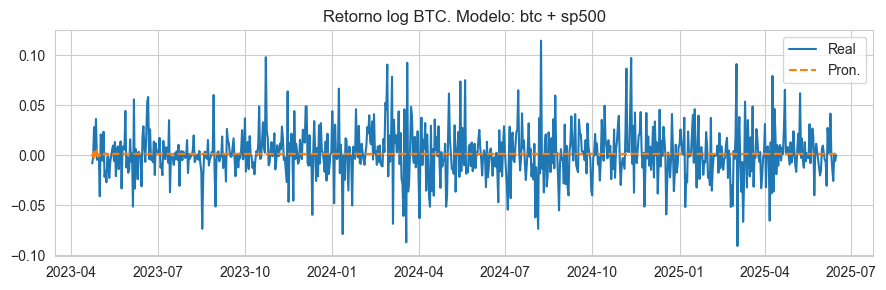

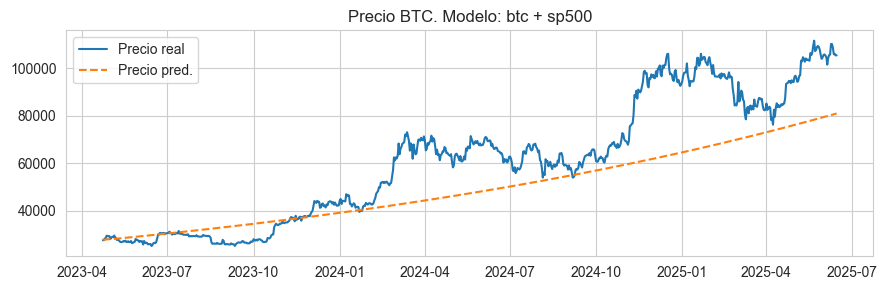


── btc + sp500 + fear_greed ──
Entrenando VARMAX

Resumen del modelo:
                                     Statespace Model Results                                     
Dep. Variable:     ['btc_log_return', 'sp500_log_return']   No. Observations:                 2153
Model:                                        VARMAX(1,1)   Log Likelihood               10868.989
                                              + intercept   AIC                         -21707.978
Date:                                    Sun, 15 Jun 2025   BIC                         -21622.859
Time:                                            19:59:25   HQIC                        -21676.840
Sample:                                        02-01-2018                                         
                                             - 12-24-2023                                         
Covariance Type:                                      opg                                         
Ljung-Box (L1) (Q):             0.00, 

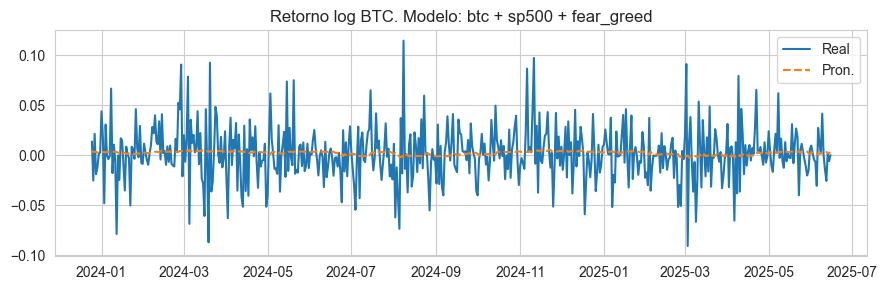

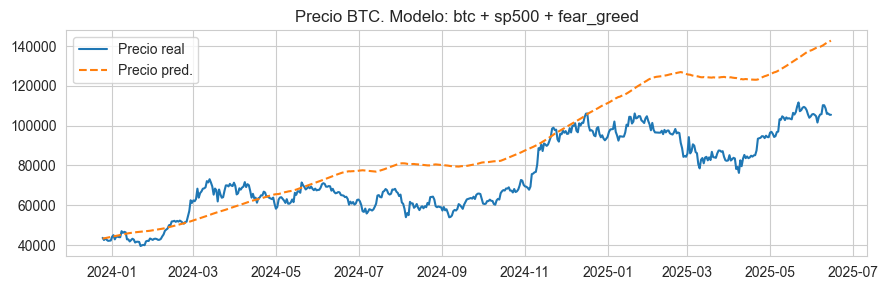


── btc + btc_rsi ──
Entrenando VAR

Resumen del modelo:
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 15, Jun, 2025
Time:                     19:59:25
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -3.73472
Nobs:                     3100.00    HQIC:                  -3.87706
Log likelihood:          -2550.36    FPE:                  0.0191242
AIC:                     -3.95681    Det(Omega_mle):       0.0184398
--------------------------------------------------------------------
Results for equation btc_log_return
                        coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------------
const                     -0.023924         0.006664           -3.590           0.000
L1.btc_log_return         -0.117887         0.027627        

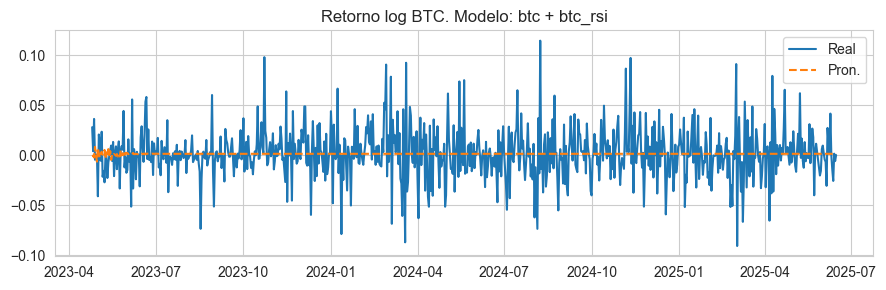

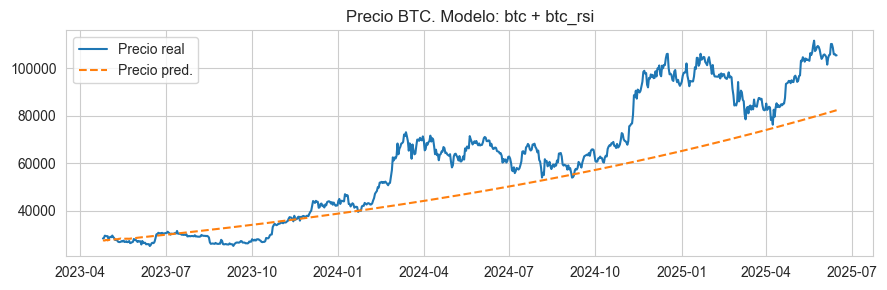


── btc + fear_greed ──
Entrenando VARMAX

Resumen del modelo:
                                 Statespace Model Results                                
Dep. Variable:     ['btc_log_return', 'btc_rsi']   No. Observations:                 2153
Model:                               VARMAX(1,1)   Log Likelihood               -2682.427
                                     + intercept   AIC                           5394.853
Date:                           Sun, 15 Jun 2025   BIC                           5479.973
Time:                                   19:59:27   HQIC                          5425.991
Sample:                               02-01-2018                                         
                                    - 12-24-2023                                         
Covariance Type:                             opg                                         
Ljung-Box (L1) (Q):             1.94, 7.33   Jarque-Bera (JB):    19663.46, 2108.09
Prob(Q):                        0.16, 0.01 

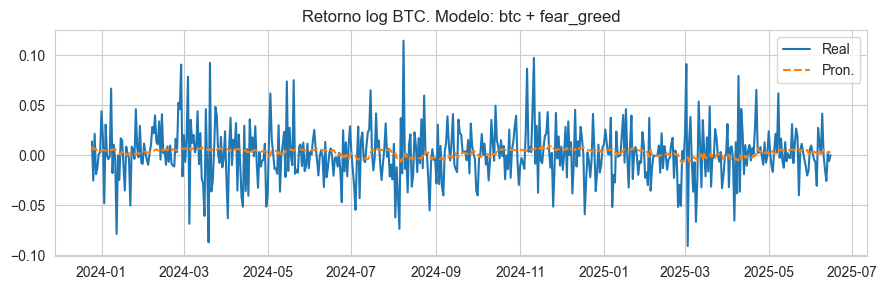

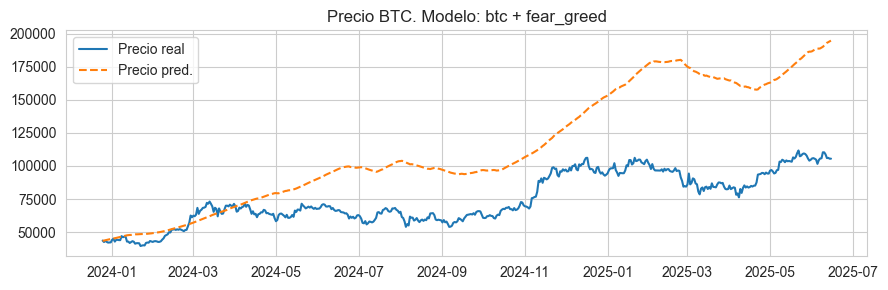


── btc + trend_diff ──
Entrenando VAR

Resumen del modelo:
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 15, Jun, 2025
Time:                     19:59:27
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -3.15317
Nobs:                     3118.00    HQIC:                  -3.26005
Log likelihood:          -3586.77    FPE:                  0.0361565
AIC:                     -3.31990    Det(Omega_mle):       0.0351795
--------------------------------------------------------------------
Results for equation btc_log_return
                        coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------------
const                      0.001217         0.000693            1.755           0.079
L1.btc_log_return         -0.020251         0.018015     

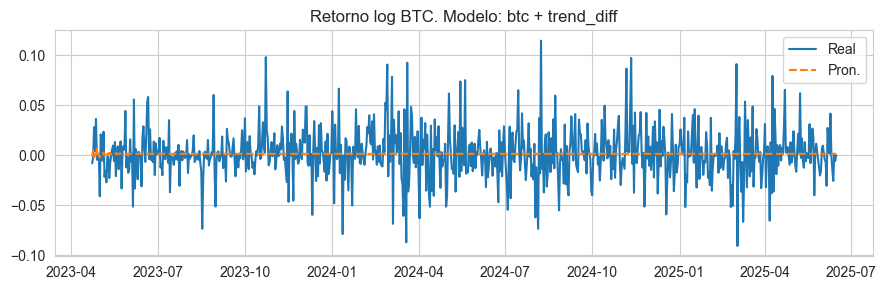

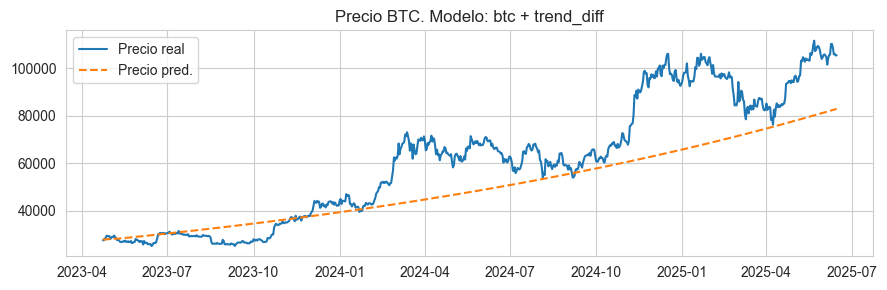


── btc + btc_rsi + active_addreses ──
Entrenando VARMAX

Resumen del modelo:
                                 Statespace Model Results                                
Dep. Variable:     ['btc_log_return', 'btc_rsi']   No. Observations:                 3128
Model:                               VARMAX(1,1)   Log Likelihood               -4034.482
                                     + intercept   AIC                           8098.963
Date:                           Sun, 15 Jun 2025   BIC                           8189.685
Time:                                   19:59:30   HQIC                          8131.526
Sample:                               10-01-2014                                         
                                    - 04-24-2023                                         
Covariance Type:                             opg                                         
Ljung-Box (L1) (Q):             0.01, 0.01   Jarque-Bera (JB):    16120.68, 2631.80
Prob(Q):                    

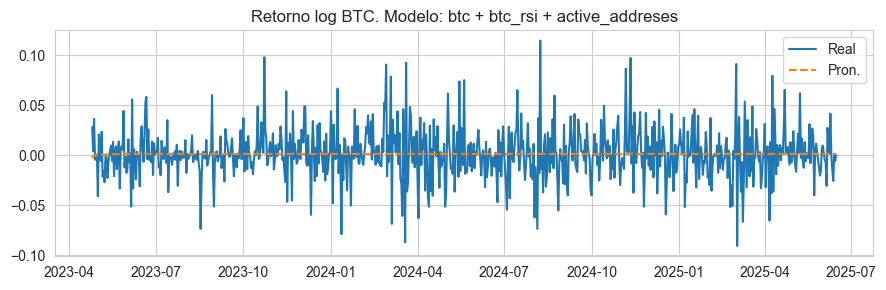

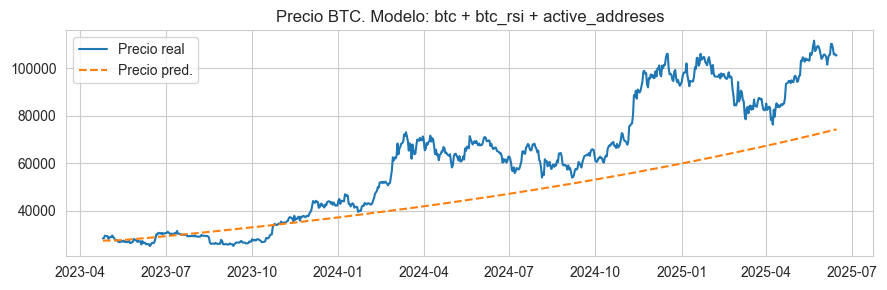


── btc + fear_greed + active + rsi ──
Entrenando VARMAX

Resumen del modelo:
                                 Statespace Model Results                                
Dep. Variable:     ['btc_log_return', 'btc_rsi']   No. Observations:                 2153
Model:                               VARMAX(1,1)   Log Likelihood               -2750.291
                                     + intercept   AIC                           5534.581
Date:                           Sun, 15 Jun 2025   BIC                           5631.050
Time:                                   19:59:31   HQIC                          5569.870
Sample:                               02-01-2018                                         
                                    - 12-24-2023                                         
Covariance Type:                             opg                                         
Ljung-Box (L1) (Q):            0.05, 14.30   Jarque-Bera (JB):    20525.34, 1545.77
Prob(Q):                    

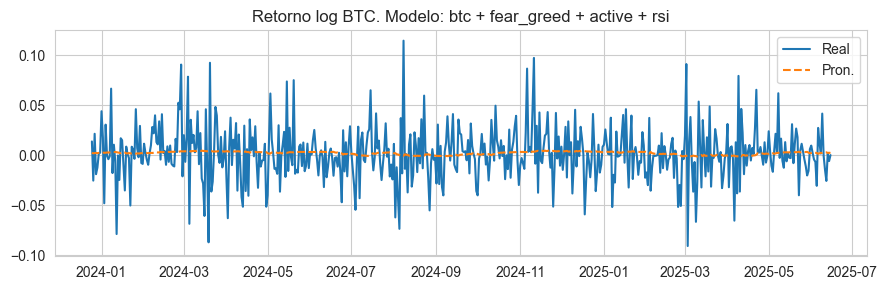

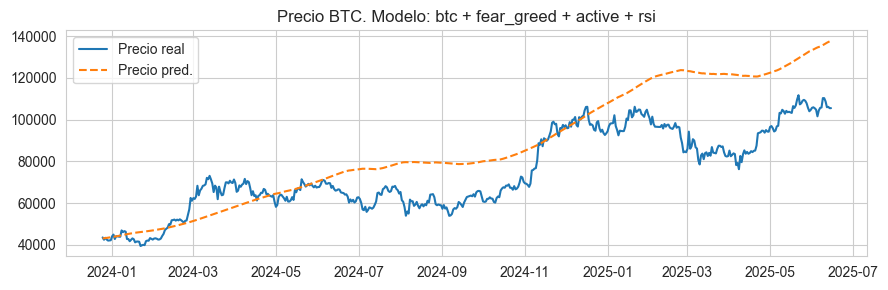

In [47]:
resultados = []

for nombre, vars_ in modelos.items():
    print(f"\n── {nombre} ──")
    endog, exog = split_endog_exog(vars_)
    Y, X = load_window(df, endog, exog)
    Y_tr, Y_te, X_tr, X_te = split_train_test(Y, X, split=0.8)
    model = fit_model(Y_tr, X_tr)
    resultado = eval_and_plot(model, Y_te, X_te, df['btc_close'], nombre)
    if resultado:
        resultado["modelo"] = nombre
        resultados.append(resultado)

In [48]:
tabla = pd.DataFrame(resultados)
tabla = tabla[["modelo", "aic", "bic", "rmse_ret", "rmse_price"]]
tabla_ordenada = tabla.sort_values(by="aic")  # o por cualquier otro criterio
print("\n📊 Comparación de modelos:")
print(tabla_ordenada.to_string(index=False))


📊 Comparación de modelos:
                         modelo           aic           bic  rmse_ret   rmse_price
       btc + sp500 + fear_greed -21707.977999 -21622.858736  0.027036 20542.677831
                    btc + sp500    -15.867559    -15.755323  0.025004 17056.554177
                  btc + btc_rsi     -3.956810     -3.734725  0.025072 16755.664177
               btc + trend_diff     -3.319903     -3.153173  0.025000 16341.873059
               btc + fear_greed   5394.853282   5479.972545  0.027290 48469.331541
btc + fear_greed + active + rsi   5534.581152   5631.049650  0.027004 18727.482106
btc + btc_rsi + active_addreses   8098.963194   8189.685430  0.025033 20086.072966
